In [49]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

import sys
sys.path.append('..')
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling, diagnostic
import selex_dca, utils
import tworound_potts

In [2]:
round_ids = ['Input_R1_N', 'OplusR1_N', 'OplusR2_N']

dtype = torch.float32

In [92]:
from importlib import reload
# reload(utils)
# reload(data_loading)
reload(tworound_potts)

<module 'tworound_potts' from '/home/scrotti/Aptamer2025py/experiments/tworound_potts.py'>

In [15]:
sequences, log_multinomial_factors = utils.sequences_from_files_ab6(round_ids, return_log_multinomial_factors=True, 
                                                                   dirpath='/home/scrotti/Aptamer2025py/experiments/saved/train_test_split/ab6_black_train')

In [16]:
sequences_oh = [utils.one_hot(seq, num_classes=21) for seq in sequences]
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh])

In [17]:
# device = torch.device('cpu')
device = utils.best_device()

Selected device: cuda


In [25]:
reload(energy_models)
reload(selex_distribution)
reload(callback)

<module 'callback' from '/home/scrotti/Aptamer2025py/experiments/../callback.py'>

In [100]:
weight_decay = 0
lr = 1e-0
checkpoint_filename = 'ab6_black'
optim = 'SGD'

In [94]:
k_indep, h_indep = training.init_from_indep_sites(sequences_oh, total_reads)

In [101]:
model, data_loaders, chains, optimizer, log_weights, callbacks = tworound_potts.train_tworound_potts(
    sequences_oh, 
    total_reads, 
    log_multinomial_factors,
    max_epochs = 2,
    lr = lr,
    optim = optim,
    weight_decay = weight_decay,
    device = device,
    checkpoint_filename = checkpoint_filename
)

 0.00%[                                                                                                       …

In [124]:
max_epochs = 5000

model, data_loaders, chains, optimizer, log_weights, callbacks = tworound_potts.resume_training(
    model, data_loaders, chains, optimizer, log_weights, callbacks,
    max_epochs, total_reads, log_multinomial_factors)

 0.00%[                                                                                                       …

In [125]:
(callback_convergence, callback_pearson_covariance, 
    callback_checkpoint, callback_params) = callbacks

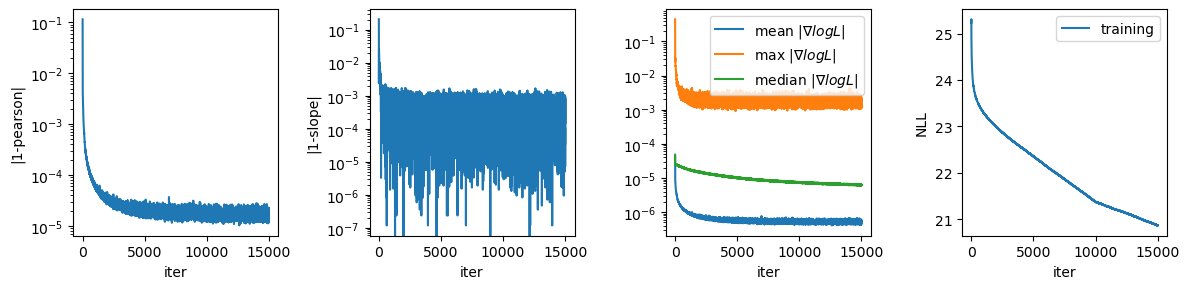

In [126]:
callback_convergence.plot();

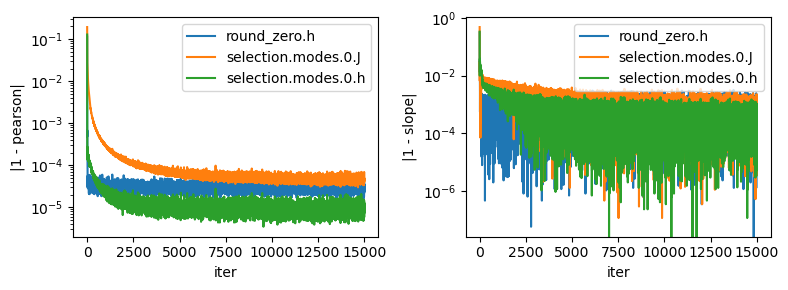

In [127]:
callback_convergence.plot_pearson_detail(figsize=(8,3));

(<Figure size 800x300 with 2 Axes>,
 array([<Axes: title={'center': 'Pearson $C_{ij}$ Ns0'}, xlabel='iter', ylabel='$|1-\\rho|$'>,
        <Axes: title={'center': 'Pearson $C_{ij}$ ps'}, xlabel='iter', ylabel='$|1-\\rho|$'>],
       dtype=object))

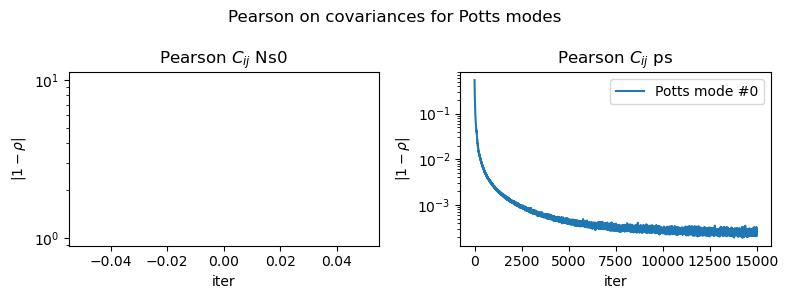

In [128]:
callback_pearson_covariance.plot(figsize=(8,3))

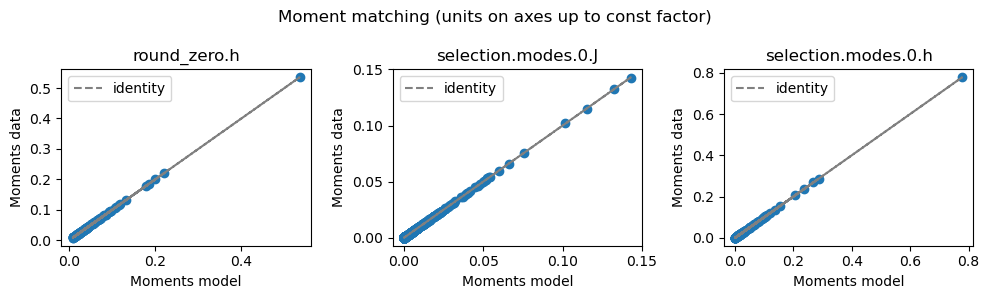

In [129]:
training.scatter_moments(model, data_loaders, chains, total_reads, figsize=(10,3));

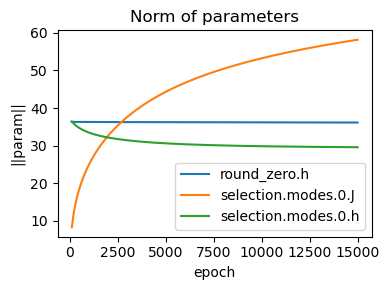

In [130]:
fig, ax = callback_params.plot_norm()
# ax.set_ylim((0,6))

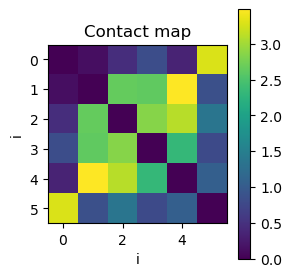

In [131]:
potts_zerosum = model.selection.modes[0].set_zerosum_gauge()
J = potts_zerosum.J.detach().cpu()
h = potts_zerosum.h.detach().cpu()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(J)
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()
plt.title('Contact map');

Computing mixing time for chains initialized at site frequencies


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Mixing time not reached within 500 sweeps.

Computing mixing time for chains initialized uniformly


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Mixing time not reached within 500 sweeps.

Sampling from the two sets of chains...


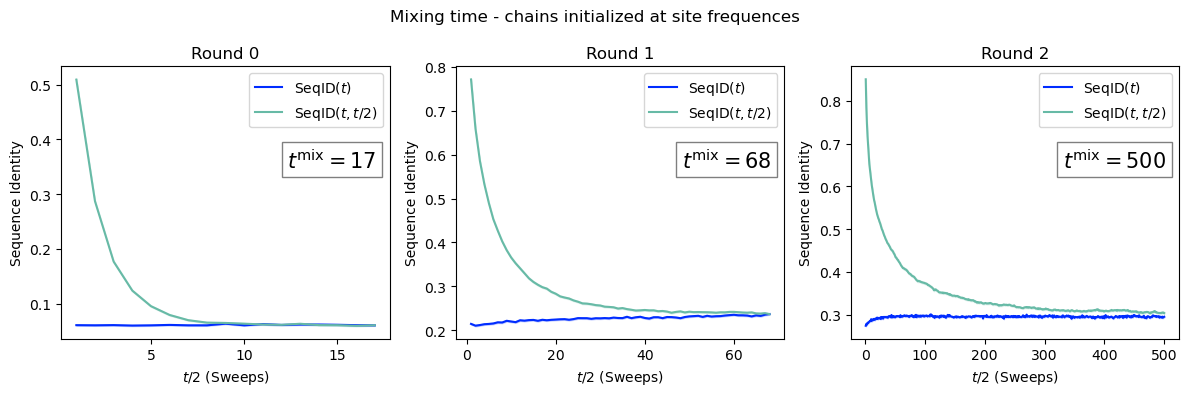

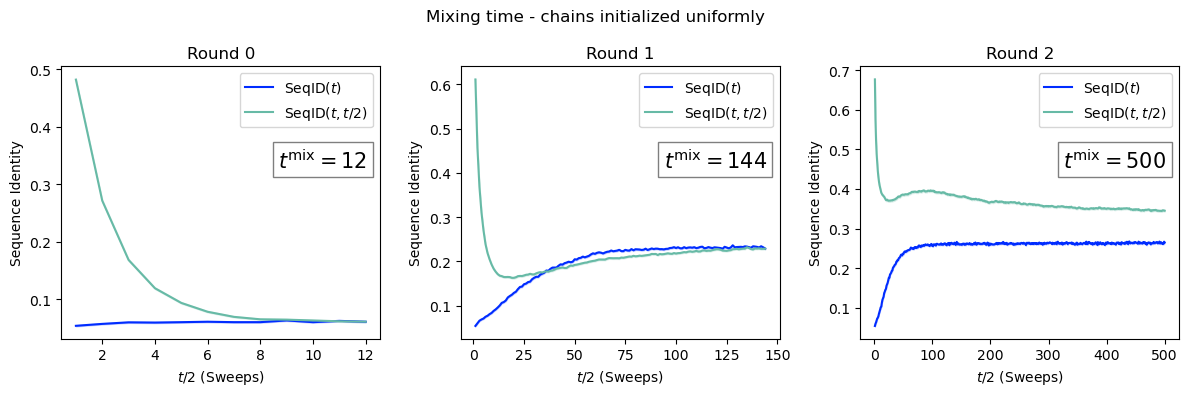

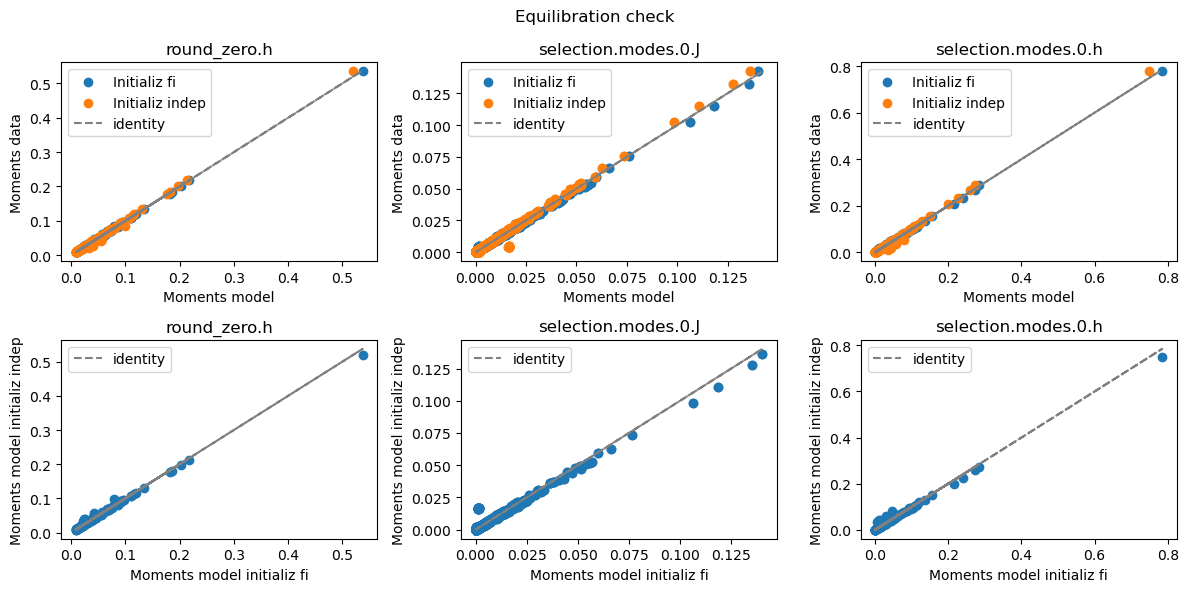

In [132]:
n_chains_equil = 10**4
n_max_sweeps = 10**3

diagnostic.check_equilibration(model, data_loaders, total_reads, 
                                log_multinomial_factors=log_multinomial_factors,
                                n_max_sweeps=n_max_sweeps, n_chains_equil=n_chains_equil, 
                                device=device);

In [122]:
(h ** 2).mean(1)

tensor([0.2136, 0.3784, 0.5677, 0.4567, 0.4204, 0.3380])

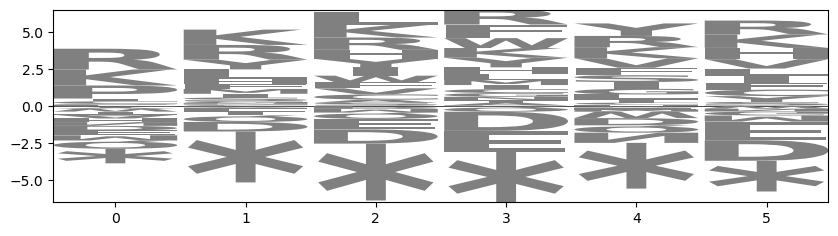

In [112]:
import logomaker
import pandas as pd

logomaker.Logo(pd.DataFrame(h, columns=list(utils.TOKENS_PROTEIN)))

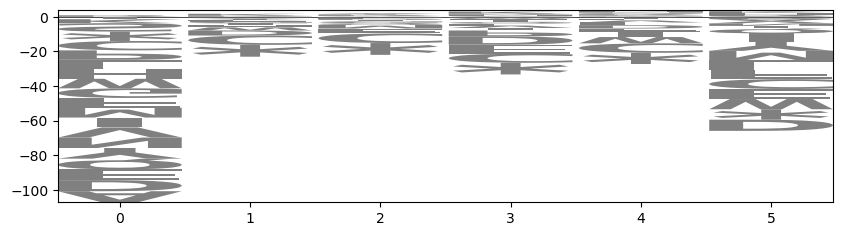

In [82]:
logomaker.Logo(pd.DataFrame(h_indep, columns=list(utils.TOKENS_PROTEIN)))

## Compare against counts

In [84]:
sequences_unique_all, counts_unique, enrichments = utils.group_rounds(sequences_oh, return_enrichments=True)

Extracting unique sequences and counts at each round...
Merging sequences from all rounds in a single container...
Assigning counts at each round to unique sequences...
	Starting round 0...
	Starting round 1...
	Starting round 2...
Calculating enrichments...
Finished


In [85]:
logNst_unique = [- model.compute_energy_up_to_round(sequences_unique_all, t).detach()
                for t in range(n_rounds)]

RuntimeError: Expected all tensors to be on the same device, but got mat is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA_addmv_)

In [ ]:
n_subsample = 10**5
n_seq = len(sequences_unique_all)
idx = random.sample(range(n_seq), min(n_subsample, n_seq))
fig1, ax = plt.subplots(figsize=(4,3))
for t in range(n_rounds):
    ax.scatter(logNst_unique[t][idx], torch.log(counts_unique[t][idx]), 
               label=f'Round {t}', s=2)
    ax.set_xlabel('log Nst')
    ax.set_ylabel('log count')
    ax.legend()
ax.set_title('logNst vs log count')

In [ ]:
logps_unique = - model.selection_energy_at_round(sequences_unique_all, 1).detach()

In [ ]:
utils.binned_logenrichments(model, sequences_unique_all, enrichments, counts_unique, 
                            plot=True, n_subsample=n_subsample);

In [ ]:
logomaker.Logo(pd.DataFrame(fi[0], columns=list(utils.TOKENS_PROTEIN)));

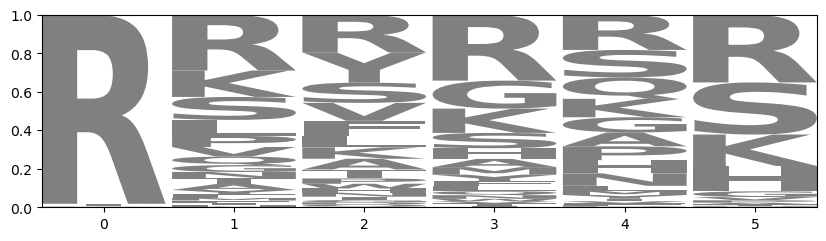

In [82]:
logomaker.Logo(pd.DataFrame(fi[-1], columns=list(utils.TOKENS_PROTEIN)));

In [80]:
potts_zerosum = model.selection.modes[0].set_zerosum_gauge().cpu()
J = potts_zerosum.J.detach()
h = potts_zerosum.h.detach()

Selection field


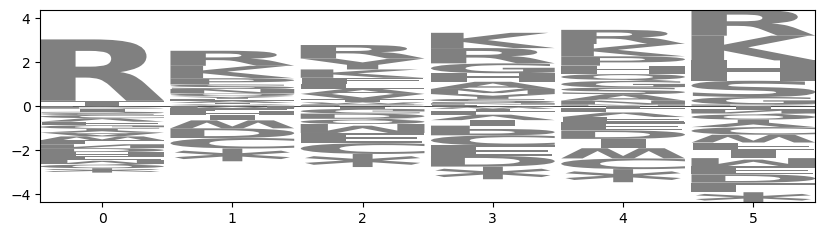

In [81]:
logomaker.Logo(pd.DataFrame(h, columns=list(utils.TOKENS_PROTEIN)))
print('Selection field');